[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/efficientcube/blob/main/notebooks/Rubik's_Cube.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/kyo-takano/efficientcube/blob/main/notebooks/Rubik's_Cube.ipynb)

# EfficientCube: Rubik's Cube

[![TMLR](https://img.shields.io/badge/TMLR_1188-112467?style=for-the-badge)](https://openreview.net/forum?id=bnBeNFB27b)
[![GitHub Repository](https://img.shields.io/badge/-Repository-2dba4e?logo=github&style=for-the-badge)](https://github.com/kyo-takano/efficientcube)

This notebook is associated with the following publication:
> K. Takano. Self-Supervision is All You Need for Solving Rubik's Cube. Transactions on Machine Learning Research, ISSN 2835-8856, 2023. URL: https://openreview.net/forum?id=bnBeNFB27b.

---

## Overview
This standalone notebook serves as a demonstration of the method proposed in the paper and provides the necessary code to reproduce the experiment. Please refer to the paper for the methodological overview and further details.

## Usage
For the demonstration purpose, the default number of training steps is set to `10000`, and the beam width for inference is set to `2**11`. To replicate our best-reported result, set `TrainConfig.num_steps = 2000000` and `SearchConfig.beam_width = 2**18`. However, note that it will likely take several days to complete both training and inference. If you wish to speed up the training/inference, the mixed precision mode can be enabled by setting `ENABLE_FP16` to `True`.

## Setup

In [ ]:
class TrainConfig:
    max_depth = 26                          # God's Number
    batch_size_per_depth = 1000
    num_steps = 10000
    learning_rate = 1e-3
    INTERVAL_PLOT, INTERVAL_SAVE = 100, 1000
    ENABLE_FP16 = False                     # Set this to True if you want to train the model faster

class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

In [ ]:
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
from contextlib import nullcontext
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from cycler import cycler; plt.rcParams["axes.prop_cycle"] = cycler(color=["#000000", "#2180FE", "#EB4275"])
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 2
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-76ff9c64-565d-0747-fdb1-de144ca34ad6)


## Environment
Rubik's Cube is operated based on the locations and colors of 6$\times$9 stickers.

We employ [Quarter-Turn Metric](https://www.speedsolving.com/wiki/index.php/Metric#QTM) (90° turns count as one move; 180°, two) for both scrambling and solving the puzzle.


In [ ]:
class Cube3:
    """
    A class for 3x3x3 Rubik's Cube
    """
    def __init__(self):
        self.DTYPE = np.int64

        # Define initial and goal state
        self.reset()
        self.goal = np.arange(0, 9 * 6, dtype=self.DTYPE) // 9

        # Define moves
        ## faces and turns
        faces = ["U", "D", "L", "R", "B", "F"]
        ## [90 degrees clockwise, 90 degrees counter-clockwise]
        degrees = ["", "'"]
        degrees_inference = degrees[::-1]
        self.moves = [f"{f}{n}" for f in faces for n in degrees]
        self.moves_inference = [f"{f}{n}" for f in faces for n in degrees_inference]

        # Opposite faces
        self.pairing = {
            "R": "L",
            "L": "R",
            "F": "B",
            "B": "F",
            "U": "D",
            "D": "U",
        }
        # Prohibit obviously redundant moves.
        self.moves_available_after = {
            m: [v for v in self.moves if v[0] != m[0]] + [m]
            for m in self.moves
        } # self-cancelling moves on the same face

        # [OPTIMIZATION] slicing by move string (e.g., R', U, F) => indices (e.g., 2, 6, 1)
        self.moves_ix = [self.moves.index(m) for m in self.moves]
        self.moves_ix_available_after = {
            self.moves.index(m): [self.moves.index(m) for m in available_moves]
            for m, available_moves in self.moves_available_after.items()
        }
        self.moves_ix_inference = [self.moves.index(m) for m in self.moves_inference]
        self.pairing_ix = {
            0: 1,
            1: 0,
            2: 3,
            3: 2,
            4: 5,
            5: 4,
        } # Points to the opposite face index

        # Vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        """Resets the cube state to the solved state."""
        self.state = np.arange(0, 9 * 6, dtype=self.DTYPE) // 9

    def is_solved(self):
        """Checks if the cube is in the solved state."""
        return np.all(self.state == self.goal)

    def finger(self, move):
        """Applies a single move on the cube state using move string."""
        self.state[self.sticker_target[move]] = self.state[self.sticker_source[move]]

    def finger_ix(self, ix):
        """The same `finger` method **but using indices of moves for faster execution"""
        self.state[self.sticker_target_ix[ix]] = self.state[self.sticker_source_ix[ix]]

    def apply_scramble(self, scramble):
        """Applies a sequence of moves (scramble) to the cube state."""
        if isinstance(scramble, str):
            scramble = scramble.split()
        for m in scramble:
            if m[-1]=='2':
                for _ in range(2):
                    self.finger(m[0])
            else:
                    self.finger(m)

    def scrambler(self, scramble_length):
        """
        Generates a random scramble of given length and returns the cube state and scramble moves as a generator.
        Please note that index-based implementations (faster) follow commented lexical logics.
        """
        while True:
            # Reset the cube state, scramble, and return cube state and scramble moves
            self.reset()
            scramble = []

            for i in range(scramble_length):
                if i:
                    last_move = scramble[-1]
                    if i > 1:   # [3rd~ moves]
                        while True:
                            # move = random.choice(self.moves_available_after[last_move])
                            move = random.choice(self.moves_ix_available_after[last_move])

                            if scramble[-2] == last_move == move:
                                # Three subsequent moves on the same face, which could be one
                                continue
                            # elif (
                            #     scramble[-2][0] == move[0] and len(scramble[-2] + move) == 3
                            #     and last_move[0] == self.pairing[move[0]]
                            # ):
                            elif (
                                scramble[-2]//2 == move//2 and scramble[-2]%2 != move%2
                                and last_move//2 == self.pairing_ix[move//2]
                            ):
                                # Two mutually canceling moves sandwiching an opposite face move
                                continue
                            else:
                                break
                    else:       # [2nd move]
                        # move = random.choice(self.moves_available_after[last_move])
                        move = random.choice(self.moves_ix_available_after[last_move])
                else:           # [1st move]
                    # move = random.choice(self.moves)
                    move = random.choice(self.moves_ix)

                # self.finger(move)
                self.finger_ix(move)
                scramble.append(move)

                yield self.state, move


    def __vectorize_moves(self):
        """
        Vectorizes the sticker group replacement operations for faster computation.
        This method defines ```self.sticker_target``` and ```self.sticker_source``` to manage sticker colors (target is replaced by source).
        They define indices of target and source stickers so that the moves can be vectorized.

        Colors:

                0 0 0
                0 0 0
                0 0 0
        2 2 2   5 5 5   3 3 3   4 4 4
        2 2 2   5 5 5   3 3 3   4 4 4
        2 2 2   5 5 5   3 3 3   4 4 4
                1 1 1
                1 1 1
                1 1 1

        Order of stickers on each face:

             2   5   8
             1   4   7
            [0]  3   6

        Indices of state (each starting with 9*(n-1)):

                         2   5   8
                         1   4   7
                        [0]  3   6
             20  23 26  47  50  53  29  32 35  38  41 44
             19  22 25  46  49  52  28  31 34  37  40 43
            [18] 21 24 [45] 48  51 [27] 30 33 [36] 39 42
                        11   14 17
                        10   13 16
                        [9]  12 15
        """
        self.sticker_target, self.sticker_source = dict(), dict()

        self.sticker_replacement = {
            # Sticker A is replaced by another sticker at index B -> A:B
            'U':{0: 6, 1: 3, 2: 0, 3: 7, 5: 1, 6: 8, 7: 5, 8: 2, 20: 47, 23: 50, 26: 53, 29: 38, 32: 41, 35: 44, 38: 20, 41: 23, 44: 26, 47: 29, 50: 32, 53: 35},
            'D':{9: 15, 10: 12, 11: 9, 12: 16, 14: 10, 15: 17, 16: 14, 17: 11, 18: 36, 21: 39, 24: 42, 27: 45, 30: 48, 33: 51, 36: 27, 39: 30, 42: 33, 45: 18, 48: 21, 51: 24},
            'L':{0: 44, 1: 43, 2: 42, 9: 45, 10: 46, 11: 47, 18: 24, 19: 21, 20: 18, 21: 25, 23: 19, 24: 26, 25: 23, 26: 20, 42: 11, 43: 10, 44: 9, 45: 0, 46: 1, 47: 2},
            'R':{6: 51, 7: 52, 8: 53, 15: 38, 16: 37, 17: 36, 27: 33, 28: 30, 29: 27, 30: 34, 32: 28, 33: 35, 34: 32, 35: 29, 36: 8, 37: 7, 38: 6, 51: 15, 52: 16, 53: 17},
            'B':{2: 35, 5: 34, 8: 33, 9: 20, 12: 19, 15: 18, 18: 2, 19: 5, 20: 8, 33: 9, 34: 12, 35: 15, 36: 42, 37: 39, 38: 36, 39: 43, 41: 37, 42: 44, 43: 41, 44: 38},
            'F':{0: 24, 3: 25, 6: 26, 11: 27, 14: 28, 17: 29, 24: 17, 25: 14, 26: 11, 27: 6, 28: 3, 29: 0, 45: 51, 46: 48, 47: 45, 48: 52, 50: 46, 51: 53, 52: 50, 53: 47}
        }
        for m in self.moves:
            if len(m) == 1:
                assert m in self.sticker_replacement
            else:
                if "'" in m:
                    self.sticker_replacement[m] = {
                        v: k for k, v in self.sticker_replacement[m[0]].items()
                    }
                elif "2" in m:
                    self.sticker_replacement[m] = {
                        k: self.sticker_replacement[m[0]][v]
                        for k, v in self.sticker_replacement[m[0]].items()
                    }
                else:
                    raise

            self.sticker_target[m] = list(self.sticker_replacement[m].keys())
            self.sticker_source[m] = list(self.sticker_replacement[m].values())

            for i, idx in enumerate(self.sticker_target[m]):
                assert self.sticker_replacement[m][idx] == self.sticker_source[m][i]

        # For index slicing
        self.sticker_target_ix = np.array([np.array(self.sticker_target[m]) for m in self.moves])
        self.sticker_source_ix = np.array([np.array(self.sticker_source[m]) for m in self.moves])

env = Cube3()

## Model

In [ ]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList([
            LinearBlock(embed_dim, embed_dim),
            LinearBlock(embed_dim, embed_dim)
        ])

    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        x += inputs # skip-connection
        return x

class Model(nn.Module):
    """
    Fixed architecture following DeepCubeA.
    """
    def __init__(self, input_dim=324, output_dim=len(env.moves)):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.embedding = LinearBlock(input_dim, 5000)
        self.layers = nn.ModuleList([
            LinearBlock(5000,1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000)
        ])
        self.output = nn.Linear(1000, output_dim)

    def forward(self, inputs):
        # int indices => float one-hot vectors
        x = nn.functional.one_hot(inputs, num_classes=6).to(torch.float)
        x = x.reshape(-1, self.input_dim)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output(x)
        return logits

model = Model()
model.to(device)

Model(
  (embedding): LinearBlock(
    (fc): Linear(in_features=324, out_features=5000, bias=True)
    (relu): ReLU()
    (bn): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layers): ModuleList(
    (0): LinearBlock(
      (fc): Linear(in_features=5000, out_features=1000, bias=True)
      (relu): ReLU()
      (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1-4): 4 x ResidualBlock(
      (layers): ModuleList(
        (0-1): 2 x LinearBlock(
          (fc): Linear(in_features=1000, out_features=1000, bias=True)
          (relu): ReLU()
          (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (output): Linear(in_features=1000, out_features=12, bias=True)
)

## Training

In [ ]:
class ScrambleGenerator(torch.utils.data.Dataset):
    def __init__(
            self,
            num_workers=os.cpu_count(),
            max_depth=TrainConfig.max_depth,
            total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
        ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [Cube3() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        ''' generate one scramble, consisting of `self.max_depth` data points '''
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, 54), dtype=int)
        y = np.zeros((self.max_depth,), dtype=int)
        for j in range(self.max_depth):
            state, last_move = next(self.generators[worker_idx])
            X[j, :] = state
            y[j] = last_move
        return X, y

dataloader = torch.utils.data.DataLoader(
    ScrambleGenerator(),
    num_workers=os.cpu_count(),
    batch_size=TrainConfig.batch_size_per_depth
)

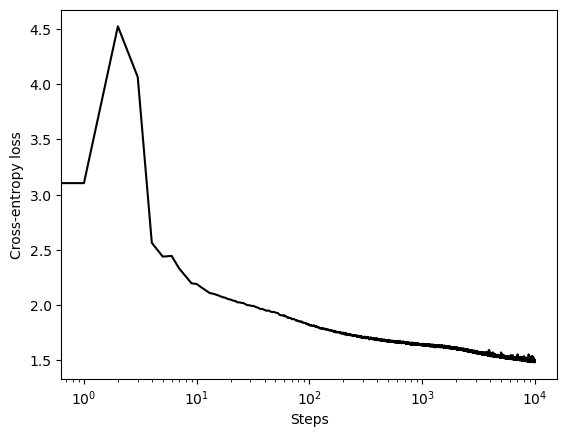

100%|██████████| 10000/10000 [1:01:55<00:00,  2.69it/s]

Model saved.
Trained on data equivalent to 10000000 solves.


In [ ]:
def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_xscale("log")
    plt.show()

def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    h = []
    ctx = torch.cuda.amp.autocast(dtype=torch.float16) if TrainConfig.ENABLE_FP16 else nullcontext()

    for i in trange(1, TrainConfig.num_steps + 1):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 54).to(device), batch_y.reshape(-1).to(device)

        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if TrainConfig.INTERVAL_PLOT and i % TrainConfig.INTERVAL_PLOT == 0:
            clear_output()
            plot_loss_curve(h)
        if TrainConfig.INTERVAL_SAVE and i % TrainConfig.INTERVAL_SAVE == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")
    print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    return model

model = train(model, dataloader)

## Inference

We test and compare on the DeepCubeA dataset

### Dataset: DeepCubeA

Downloading from GitHub

In [ ]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('### Optimal Solver ###')
filename = 'data/cube3/test/data_0.pkl'
with open(filename, 'rb') as f:
    result_Optimal = pickle.load(f)

    print(result_Optimal.keys())
    result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
    result_Optimal["solution_lengths_count"] = {
        i: result_Optimal["solution_lengths"].count(i)
        for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
    }

    print('No. of cases:', len(result_Optimal["solution_lengths"]))

print('\n### DeepCubeA ###')
filename = 'results/cube3/results.pkl'
with open(filename, 'rb') as f:
    result_DeepCubeA = pickle.load(f)

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i)
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

/DeepCubeA
### Optimal Solver ###
dict_keys(['states', 'times', 'solutions', 'num_nodes_generated'])
No. of cases: 1000

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 1000
/


In [ ]:
# Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [m[0] if m[1] == -1 else m[0] + "'" for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")

Example:
[['D', -1], ['F', 1], ['R', 1], ['U', -1], ['F', 1], ['F', 1], ['R', 1], ['U', 1], ['F', 1], ['R', 1], ['B', -1], ['R', -1], ['F', -1], ['R', -1], ['D', -1], ['U', -1], ['R', -1], ['U', -1], ['U', -1], ['R', -1], ['U', 1], ['B', -1]]
-> ['B', "U'", 'R', 'U', 'U', 'R', 'U', 'D', 'R', 'F', 'R', 'B', "R'", "F'", "U'", "R'", "F'", "F'", 'U', "R'", "F'", 'D']


### Beam Search

In [ ]:
@torch.no_grad()
def beam_search(
        env,
        model,
        beam_width=SearchConfig.beam_width,
        max_depth=SearchConfig.max_depth,
        skip_redundant_moves=True,
    ):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment.
        model: PyTorch model used to predict the next move(s).
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        skip_redundant_moves: If True, skip redundant moves.
    Output:
        if solved successfully:
            True, {'solutions':solution path, "num_nodes_generated":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    model.eval()
    with torch.cuda.amp.autocast(dtype=torch.float16) if SearchConfig.ENABLE_FP16 else nullcontext():
        # metrics
        num_nodes_generated, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.finger_ix(c_path[-1])
                    num_nodes_generated += 1
                    if env.is_solved():
                        # Revert: array of indices => array of notations
                        c_path = [str(env.moves[i]) for i in c_path]
                        return True, {'solutions':c_path, "num_nodes_generated":num_nodes_generated, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x)
            batch_p = torch.nn.functional.softmax(batch_p, dim=-1)
            batch_p = batch_p.detach().cpu().numpy()

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_ix_inference, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    if c_path and skip_redundant_moves:
                        if m not in env.moves_ix_available_after[c_path[-1]]:
                            # Two mutually canceling moves
                            continue
                        elif len(c_path) > 1:
                            # if c_path[-2] == c_path[-1] == m:
                            if c_path[-2] == c_path[-1] == m:
                                # Three subsequent moves that could be one
                                continue
                            # elif (
                            #     c_path[-2][0] == m[0] and len(c_path[-2] + m) == 3
                            #     and c_path[-1][0] == env.pairing[m[0]]
                            # ):
                            elif (
                                c_path[-2]//2 == m//2 and c_path[-2]%2 != m%2
                                and c_path[-1]//2 == env.pairing_ix[m//2]
                            ):
                                # Two mutually canceling moves sandwiching an opposite face move
                                continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]


### Solve

In [ ]:
result_ours = {
    "solutions":[],
    "num_nodes_generated":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    env.apply_scramble(scramble)
    # solve
    success, result = beam_search(env, model)
    if success:
        for k in result_ours.keys():
            result_ours[k].append(result[k])
    else:
        result_ours["solutions"].append(None)

result_ours['solution_lengths'] = [len(e) for e in result_ours['solutions'] if e]
result_ours['solution_lengths_count'] = {
    i: result_ours["solution_lengths"].count(i)
    for i in range(min(result_ours["solution_lengths"]), max(result_ours["solution_lengths"]))
}
f"Successfully solved {len(result_ours['times'])} cases out of {len(result_ours['solutions'])}"

100%|██████████| 1000/1000 [1:33:46<00:00,  5.63s/it]


'Successfully solved 1000 cases out of 1000'

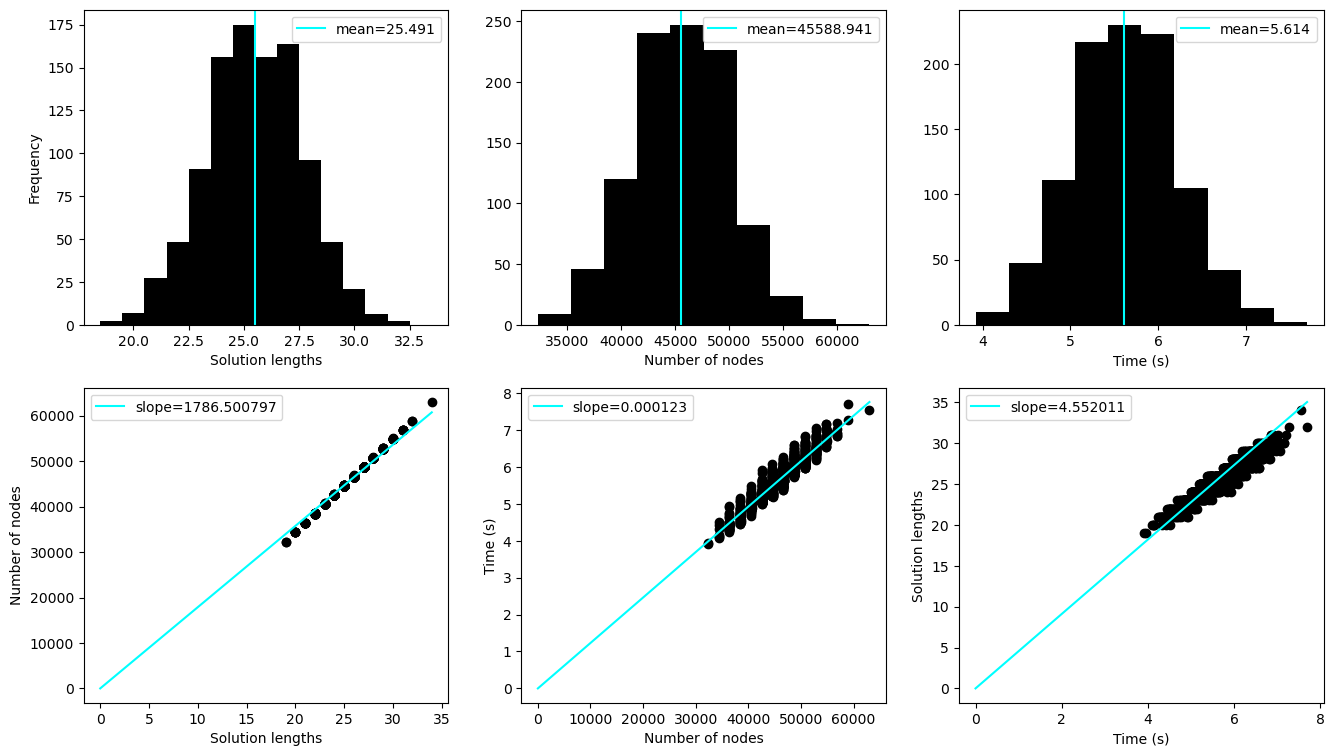

In [ ]:
# Visualize result
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths":    "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":               "Time (s)",
}

for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours[k]
    if k=="solution_lengths":
        v_count = result_ours['solution_lengths_count']
        ax[i].bar(v_count.keys(), v_count.values(), width=1.0)
    else:
        ax[i].hist(v)
    ax[i].axvline(np.mean(v), color="#00ffff", label=f"mean={np.mean(v):.3f}")
    ax[i].set_xlabel(key_to_text[k])
    ax[i].legend()

for i, (key_x, key_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    i += 3
    x, y = [result_ours[k] for k in [key_x, key_y]]
    ax[i].set_xlabel(key_to_text[key_x])
    ax[i].set_ylabel(key_to_text[key_y])

    x_range = np.linspace(0, max(x), 100)
    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    ax[i].plot(x_range, x_range * coef, label=f"slope={coef:.6f}", color="#00ffff")
    ax[i].scatter(x, y)
    ax[i].legend()

plt.show()

## Comparison to DeepCubeA

### Number of nodes vs. solution length

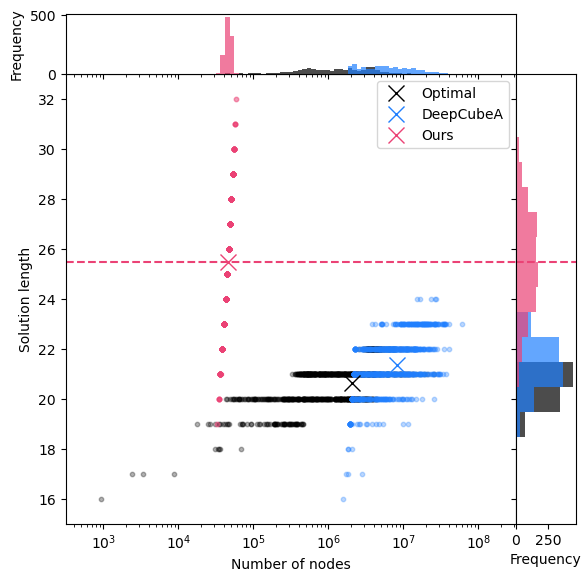

In [ ]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Solution length")
ax.set_xscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_ylim(15, max(result_ours['solution_lengths_count']))
ax_histy.set_ylim(15, max(result_ours['solution_lengths_count']))

xmin, xmax = 2.5, 8.5
ax.set_xlim(10**xmin, 10**xmax)
ax_histx.set_xlim(10**xmin, 10**xmax)
bins_x = np.logspace(xmin, xmax, 100)

################################################################################

key_x, key_y = "num_nodes_generated", "solution_lengths"

for k, data in [("Optimal", result_Optimal), ("DeepCubeA", result_DeepCubeA), ("Ours", result_ours)]:
    x, y = data[key_x], data[key_y]
    ax.scatter(x, y, s=10, alpha=0.3)
    ax_histx.hist(x, bins=bins_x, alpha=0.7)

for i, data in enumerate([result_Optimal, result_DeepCubeA, result_ours]):
    data = data["solution_lengths_count"]
    ax_histy.barh(list(data.keys()), list(data.values()), height=1, alpha=0.7)

ax_histy.axhline(np.mean(result_ours[key_y]), ls="--", color="#EB4275")
ax.axhline(np.mean(result_ours[key_y]), ls="--", color="#EB4275")

ax.plot(np.mean(result_Optimal[key_x]), np.mean(result_Optimal[key_y]),     "x", markersize=12, label="Optimal")
ax.plot(np.mean(result_DeepCubeA[key_x]), np.mean(result_DeepCubeA[key_y]), "x", markersize=12, label="DeepCubeA")
ax.plot(np.mean(result_ours[key_x]), np.mean(result_ours[key_y]),           "x", markersize=12, label="Ours")
ax.legend()

plt.show()